In [4]:
# import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

In [5]:
# Function to calculate safety stock incorporating lead time variability
def calculate_safety_stock(demand_std, lead_time, lead_time_std, service_level):
    z = stats.norm.ppf(service_level / 100)  # Convert service level percentage to Z-score
    safety_stock = z * np.sqrt((demand_std ** 2 * lead_time) + (demand_std ** 2 * lead_time_std ** 2))
    return int(safety_stock)

# Function to calculate reorder point
def calculate_reorder_point(demand_mean, lead_time, safety_stock):
    return int((demand_mean * lead_time) + safety_stock)

# Function to calculate EOQ
def calculate_eoq(demand_mean, order_cost, holding_cost):
    return int(np.sqrt((2 * demand_mean * 365* order_cost) / holding_cost))

In [6]:
simulation_days = 20
inventory_model = "Decentralized"

# Echelon 1 Table
echelon1_data = {'Warehouse': ['WH1'], 'Holding $/Unit': [1.50]}
echelon1_df = pd.DataFrame(echelon1_data)
display(echelon1_df)

# Echelon 2 Table
echelon2_data = {
    'Customer': ['C1', 'C2'],
    'Avg. Demand': [50, 40],
    'St. Dev. Demand': [10, 8],
    'Holding $/Unit': [2.00, 2.50],
    'Stock Out $/Unit': [5.00, 6.00],
    'Service Level': [95, 97]
}
echelon2_df = pd.DataFrame(echelon2_data)
display(echelon2_df)

# Network Table
network_data = {
    'Warehouse': ['WH1', 'WH1'],
    'Customer': ['C1', 'C2'],
    'Order Cost': [10, 12],
    'Avg. Lead Time': [3, 4],
    'St. Dev. Lead Time': [1, 1.5]
}
network_df = pd.DataFrame(network_data)
display(network_df)

,Warehouse,Holding $/Unit
0,WH1,1.5


,Customer,Avg. Demand,St. Dev. Demand,Holding $/Unit,Stock Out $/Unit,Service Level
0,C1,50,10,2.0,5.0,95
1,C2,40,8,2.5,6.0,97


,Warehouse,Customer,Order Cost,Avg. Lead Time,St. Dev. Lead Time
0,WH1,C1,10,3,1.0
1,WH1,C2,12,4,1.5


In [7]:
# Compute Safety Stock, Reorder Point, and EOQ
if inventory_model == "Decentralized":
    echelon2_df['Safety Stock'] = echelon2_df.apply(lambda row: calculate_safety_stock(
        row['St. Dev. Demand'], 
        network_df.loc[network_df['Customer'] == row['Customer'], 'Avg. Lead Time'].values[0],
        network_df.loc[network_df['Customer'] == row['Customer'], 'St. Dev. Lead Time'].values[0],
        row['Service Level']), axis=1)
else:  # Centralized model with risk pooling
    pooled_demand_std = np.sqrt((echelon2_df['St. Dev. Demand'] ** 2).sum())
    avg_lead_time = network_df['Avg. Lead Time'].mean()
    std_lead_time = network_df['St. Dev. Lead Time'].mean()
    pooled_safety_stock = calculate_safety_stock(pooled_demand_std, avg_lead_time, std_lead_time, echelon2_df['Service Level'].mean())
    echelon2_df['Safety Stock'] = pooled_safety_stock / len(echelon2_df)

echelon2_df['Reorder Point'] = echelon2_df.apply(lambda row: calculate_reorder_point(
    row['Avg. Demand'],
    network_df.loc[network_df['Customer'] == row['Customer'], 'Avg. Lead Time'].values[0],
    row['Safety Stock']), axis=1)

echelon2_df['EOQ'] = echelon2_df.apply(lambda row: calculate_eoq(
    row['Avg. Demand'],
    network_df.loc[network_df['Customer'] == row['Customer'], 'Order Cost'].values[0],
    row['Holding $/Unit']), axis=1)

display(echelon2_df)


,Customer,Avg. Demand,St. Dev. Demand,Holding $/Unit,Stock Out $/Unit,Service Level,Safety Stock,Reorder Point,EOQ
0,C1,50,10,2.0,5.0,95,32,182,427
1,C2,40,8,2.5,6.0,97,37,197,374


/var/folders/13/tb353hv16bg0qsrdngc6r2v40000gn/T/ipykernel_18721/4216116514.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


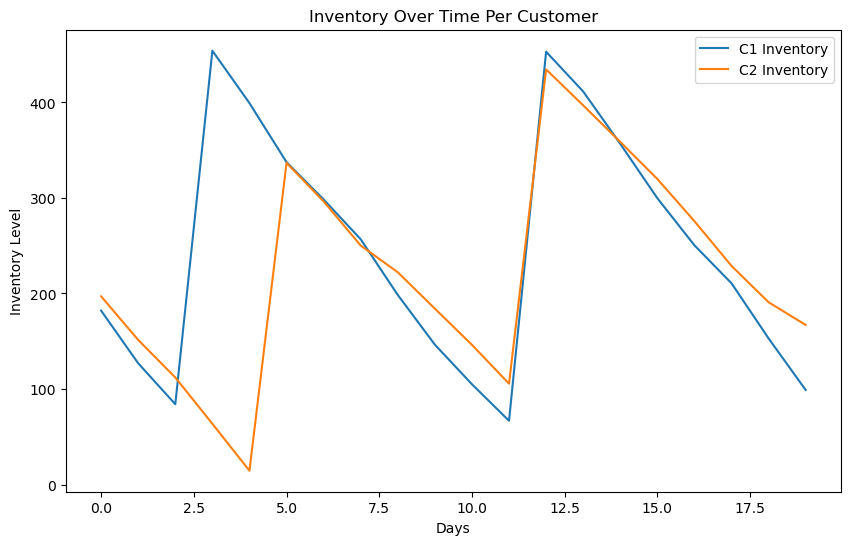

In [ ]:
# Simulation of inventory over time per customer using EOQ
fig, ax = plt.subplots(figsize=(10, 6))
customer_inventory = {customer: [] for customer in echelon2_df['Customer']}
customer_current_inventory = echelon2_df.set_index('Customer')['Reorder Point'].to_dict()
customer_order_quantity = echelon2_df.set_index('Customer')['EOQ'].to_dict()
order_pending = {customer: False for customer in echelon2_df['Customer']}
lead_time_remaining = {customer: 0 for customer in echelon2_df['Customer']}

total_inventory_levels = []

for day in range(simulation_days):
    total_inventory = 0
    for customer in customer_inventory.keys():
        customer_inventory[customer].append(customer_current_inventory[customer])
        total_inventory += customer_current_inventory[customer]
        
        if order_pending[customer]:
            lead_time_remaining[customer] -= 1
            if lead_time_remaining[customer] <= 0:
                customer_current_inventory[customer] += customer_order_quantity[customer]
                order_pending[customer] = False
        
        daily_demand = np.random.normal(
            echelon2_df.loc[echelon2_df['Customer'] == customer, 'Avg. Demand'].values[0],
            echelon2_df.loc[echelon2_df['Customer'] == customer, 'St. Dev. Demand'].values[0]
        )
        
        customer_current_inventory[customer] = max(0, customer_current_inventory[customer] - daily_demand)
        
        if customer_current_inventory[customer] <= echelon2_df.loc[echelon2_df['Customer'] == customer, 'Reorder Point'].values[0] and not order_pending[customer]:
            order_pending[customer] = True
            lead_time_remaining[customer] = int(np.random.normal(
                network_df.loc[network_df['Customer'] == customer, 'Avg. Lead Time'].values[0],
                network_df.loc[network_df['Customer'] == customer, 'St. Dev. Lead Time'].values[0]
            ))
    
    total_inventory_levels.append(total_inventory)
    
for customer, inventory_levels in customer_inventory.items():
    ax.plot(range(simulation_days), inventory_levels, label=f"{customer} Inventory")

ax.set_title("Inventory Over Time Per Customer")
ax.set_xlabel("Days")
ax.set_ylabel("Inventory Level")
ax.legend()

fig.show()

/var/folders/13/tb353hv16bg0qsrdngc6r2v40000gn/T/ipykernel_18721/779465584.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


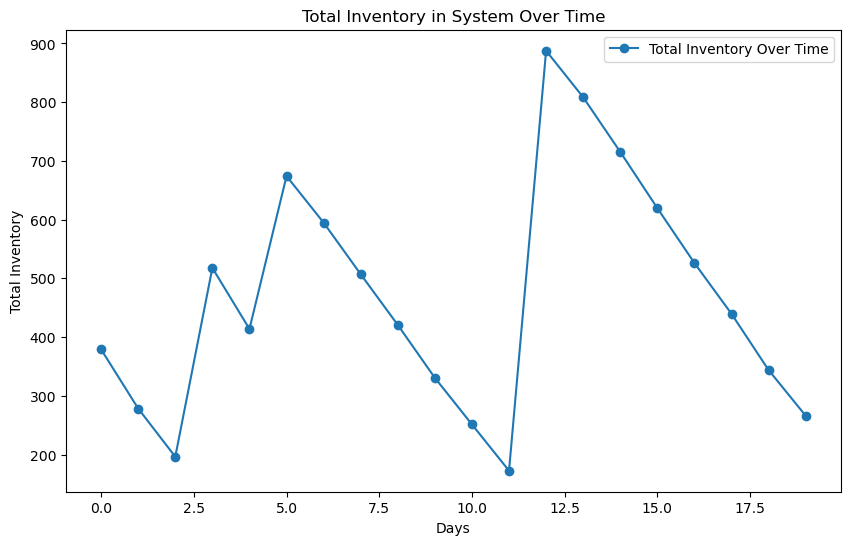

In [ ]:
# calc avg inventory
avg_inventory = sum(total_inventory_levels) / len(total_inventory_levels)

# Visualization of total inventory over time
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(simulation_days), total_inventory_levels, label="Total Inventory Over Time", marker='o')
ax.axhline(avg_inventory, color='r', linestyle='--', label=f"Average Inventory: {avg_inventory:.2f}")
ax.set_title("Total Inventory in System Over Time")
ax.set_xlabel("Days")
ax.set_ylabel("Total Inventory")
ax.legend()
fig.show()